In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allen_utils import find_probes_in_region

import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
# import SpectralEvents.spectralevents as se

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%matplotlib inline

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [3]:
# load project cache
manifest_path = os.path.join(data_root, "allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# load data for example session
session_id = 715093703
session_data = cache.get_session_data(session_id)



/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [112]:
brain_structure = 'VISp'

# identify probes in ROI
probe_ids, _ = find_probes_in_region(session_data, brain_structure)
print(f"{len(probe_ids)} probe(s) in ROI")

# import LFP data
probe_id = probe_ids[0]
lfp = session_data.get_lfp(probe_id)
print(lfp.shape)

# get LFP for ROI
# chan_roi_df = session_data.channels[(session_data.channels.probe_id==probe_id) & \
#     (session_data.channels.ecephys_structure_acronym==brain_structure)]
chan_roi_df = session_data.channels[(session_data.channels.probe_id==probe_id)]

chan_ids = chan_roi_df.index.values


1 probe(s) in ROI


/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


(11070604, 95)


In [127]:
# lfp_roi = lfp.sel(channel=slice(np.min(chan_ids), np.max(chan_ids))).T
lfp_roi = lfp.copy().T
times = lfp_roi.time.values

lfp_roi_mask = np.isin(chan_roi_df.index, lfp_roi.channel)
lfp_roi_pos = chan_roi_df[lfp_roi_mask].probe_vertical_position.values

chan_sort = np.argsort(chan_roi_df[lfp_roi_mask].probe_vertical_position.values)
lfp_roi = lfp_roi[chan_sort,:]
lfp_roi_pos = lfp_roi_pos[chan_sort]


print(f'channel distances: {np.diff(lfp_roi_pos)}')

channel distances: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]


In [128]:
def calculate_csd2d(lfp_data, delta=1):
    """Current source density (CSD) estimation

    Parameters
    ----------
    lfp_data : array, shape (n_channels, n_times)
        LFP data.
    delta : int
        Spacing between channels (um), scales the CSD.

    Returns
    -------
    csd2d : array, shape (n_channels, n_times)
        The 2nd derivative current source density estimate (csd2d)

    Notes
    -----
    The three-point finite-difference approximation of the
    second spatial derivative for computing 1-dimensional CSD
    with border electrode interpolation
    csd[electrode] = -(LFP[electrode - 1] - 2*LFP[electrode] +
                       LFP[electrode + 1]) / spacing ** 2
    """
    csd2d = -np.diff(lfp_data, n=2, axis=0) / delta ** 2
    bottom_border = csd2d[-1, :] * 2 - csd2d[-2, :]
    top_border = csd2d[0, :] * 2 - csd2d[1, :]
    csd2d = np.concatenate((top_border[None, ...], csd2d,
                            bottom_border[None, ...]), axis=0)
    return csd2d

def plot_laminar_csd(times, data, contact_labels, ax=None, colorbar=True,
                     vmin=None, vmax=None, sink='b', interpolation='spline',
                     show=True):
    """Plot laminar current source density (CSD) estimation from LFP array.

    Parameters
    ----------
    times : Numpy array, shape (n_times,)
        Sampling times (in ms).
    data : array-like, shape (n_channels, n_times)
        CSD data, channels x time.
    ax : instance of matplotlib figure | None
        The matplotlib axis.
    colorbar : bool
        If True (default), adjust figure to include colorbar.
    contact_labels : list
        Labels associated with the contacts to plot. Passed as-is to
        :func:`~matplotlib.axes.Axes.set_yticklabels`.
    vmin: float, optional
        lower bound of the color axis.
        Will be set automatically of None.
    vmax: float, optional
        upper bound of the color axis.
        Will be set automatically of None.
    sink : str
        If set to 'blue' or 'b', plots sinks in blue and sources in red,
        if set to 'red' or 'r', sinks plotted in red and sources blue.
    interpolation : str | None
        If 'spline', will smoothen the CSD using spline method,
        if None, no smoothing will be applied.

    show : bool
        If True, show the plot.

    Returns
    -------
    fig : instance of matplotlib Figure
        The matplotlib figure handle.
    """
    import matplotlib.pyplot as plt
    from scipy.interpolate import RectBivariateSpline

    if ax is None:
        _, ax = plt.subplots(1, 1, constrained_layout=True)

    if sink[0].lower() == 'b':
        cmap = "jet"
    elif sink[0].lower() == 'r':
        cmap = "jet_r"
    elif sink[0].lower() != 'b' or sink[0].lower() != 'r':
        raise RuntimeError('Please use sink = "b" or sink = "r".'
                           ' Only colormap "jet" is supported for CSD.')

    if interpolation == 'spline':
        # create interpolation function
        interp_data = RectBivariateSpline(times, contact_labels, data.T)
        # increase number of contacts
        new_depths = np.linspace(contact_labels[0], contact_labels[-1],
                                 1000)
        # interpolate
        data = interp_data(times, new_depths).T
    elif interpolation is None:
        data = data
        new_depths = contact_labels

    # if vmin and vmax are both None, set colormap such that green = zero
    if vmin is None and vmax is None:
        vmin = -np.max(np.abs(data))
        vmax = np.max(np.abs(data))

    im = ax.pcolormesh(times, new_depths, data,
                       cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('electrode depth')
    if colorbar:
        color_axis = ax.inset_axes([1.05, 0, 0.02, 1], transform=ax.transAxes)
        plt.colorbar(im, ax=ax, cax=color_axis).set_label(r'$CSD (uV/um^{2})$')

    plt.tight_layout()

    return ax.get_figure()

In [129]:
csd = calculate_csd2d(lfp_roi, delta=40e3)

In [136]:
bounds = np.arange(10_000,11_000,1)


In [137]:
csd.shape

(95, 11070604)

/tmp/ipykernel_5224/1616169997.py:109: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


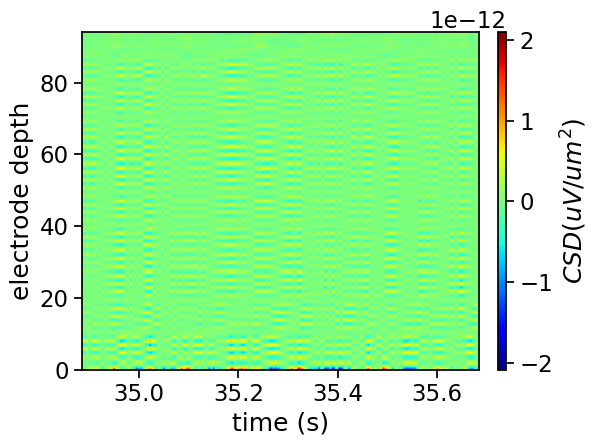

In [ ]:
_ = plot_laminar_csd(times[bounds], csd[:,bounds], list(range(csd.shape[0])))
# plt.ylim(10, 20)

In [11]:
csd[:,bounds].shape

(23, 1000)

In [85]:
chan_roi_df

,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,,,,,,,,
850261692,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,249,11,810755801,2500,VISp,385.0,VISp,8566.0,1560.0,8219.0
850261696,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,251,27,810755801,2520,VISp,385.0,VISp,8571.0,1537.0,8218.0
850261702,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,254,59,810755801,2560,VISp,385.0,VISp,8579.0,1501.0,8215.0
850261704,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,255,27,810755801,2560,VISp,385.0,VISp,8581.0,1489.0,8214.0
850261710,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,258,59,810755801,2600,VISp,385.0,VISp,8589.0,1453.0,8211.0
...,...,...,...,...,...,...,...,...,...,...,...
850261858,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,332,43,810755801,3340,VISp,385.0,VISp,8780.0,625.0,8119.0
850261862,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,334,59,810755801,3360,VISp,385.0,VISp,8786.0,604.0,8118.0
850261866,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,336,43,810755801,3380,VISp,385.0,VISp,8792.0,583.0,8117.0
